In [5]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['axes.formatter.useoffset'] = False

import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, LogLocator, MaxNLocator, FormatStrFormatter, MultipleLocator
import numpy as np
import pandas as pd
import os
import corner
from cmcrameri import cm
from scipy.interpolate import PchipInterpolator
from copy import deepcopy

In [6]:
%matplotlib inline
# %config InlineBackend.figure_format='retina'
# %matplotlib widget

In [7]:
import utils.load_grid as lg
from proteus.config import read_config
from proteus.utils.constants import M_earth, M_jupiter, R_earth, R_jupiter

In [8]:
fwl_dir = os.environ.get("FWL_DATA")

In [9]:
def _get_exo_data():
    popfile = os.path.join(fwl_dir, "planet_reference", "Exoplanets", "DACE_PlanetS.csv")
    return pd.read_csv(popfile,comment="#")

def _get_mr_data():
    z19 = os.path.join(fwl_dir, "mass_radius", "Mass-radius", "Zeng2019")

    # Set paths
    curves = {
        r"1% H$_2$ (700 K)":    os.path.join(z19, "Earthlike1h700K1mbar.txt"),
        r"1% H$_2$ (500 K)":    os.path.join(z19, "Earthlike1h500K1mbar.txt"),
        r"100% H$_2$O (700 K)": os.path.join(z19, "massradius_100percentH2O_700K_1mbar.txt"),
        r"50% H$_2$O (700 K)": os.path.join(z19, "massradius_50percentH2O_700K_1mbar.txt"),
        r"MgSiO$_3$":           os.path.join(z19, "massradiusmgsio3.txt"),
        "Earth-like":           os.path.join(z19, "massradiusEarthlikeRocky.txt"),
    }

    # Replace paths with the data
    for k in curves.keys():
        data = np.loadtxt(curves[k]).T
        mask = np.argsort(data[0])
        curves[k] = [data[0][mask],data[1][mask]]

    return curves

# Get exoplanet values from database
exo = _get_exo_data()
print(list(exo.keys()))

exo_mas_val = exo["Planet Mass [Mjup]"]             * M_jupiter / M_earth
exo_mas_upp = exo["Planet Mass - Upper Unc [Mjup]"] * M_jupiter / M_earth
exo_mas_low = exo["Planet Mass - Lower Unc [Mjup]"] * M_jupiter / M_earth

exo_rad_val = exo["Planet Radius [Rjup]"]             * R_jupiter / R_earth
exo_rad_upp = exo["Planet Radius - Upper Unc [Rjup]"] * R_jupiter / R_earth
exo_rad_low = exo["Planet Radius - Lower Unc [Rjup]"] * R_jupiter / R_earth

exo_age_val = np.array(exo["Stellar Age [Gyr]"]   )  * 1e9    # yr
exo_rho_val = np.array(exo["Planet Density [g/cm**3] - Computation"]) # g cm-3

# Get Mass-Radius curves from files
mrdata = _get_mr_data()

['Unnamed: 0', 'Planet Name', 'Planet Letter', 'Host Name', 'TIC ID', 'Gaia DR3 ID', 'Discovery Year', 'Discovery Method', 'Discovery Facility', 'Discovery Locale', 'Number of stars', 'Number of planets', 'Reference', 'ADS link', 'Last Updated', 'Planet Mass [Mjup]', 'Planet Mass - Upper Unc [Mjup]', 'Planet Mass - Lower Unc [Mjup]', 'Relative Mass Error', 'Planet Msin(i) [Mjup]', 'Planet Msin(i) - Upper Unc [Mjup]', 'Planet Msin(i) - Lower Unc [Mjup]', 'Planet Radius [Rjup]', 'Planet Radius - Upper Unc [Rjup]', 'Planet Radius - Lower Unc [Rjup]', 'Relative Radius Error', 'Orbital Period [days]', 'Orbital Period - Upper Unc [days]', 'Orbital Period - Lower Unc [days]', 'Orbit Semi-Major axis [au]', 'Orbit Semi-Major axis - Upper Unc [au]', 'Orbit Semi-Major axis - Lower Unc [au]', 'Source of the Orbit Semi-Major axis', 'Eccentricity', 'Eccentricity - Upper Unc', 'Eccentricity - Lower Unc', 'Eccentricity Upper Limit Flag', 'Insolation Flux [Earth Flux]', 'Insolation Flux - Upper Unc [Ea

In [10]:
t0 = 1e2
m_max = 5
m_min = 0.1

In [11]:
pgrid_dir = "data/scratch/l98d_habrok4/"
cases = lg.get_cases(pgrid_dir)#, only_completed=True)
ncases = len(cases)

cnums = [int(s.split("_")[-1]) for s in cases]
stts = lg.get_statuses(pgrid_dir)
helps, hvars = lg.load_helpfiles(cases)

confs = []
for f in cases:
    confs.append( read_config(f+"/init_coupler.toml") )

# transit, eclipse = lg.load_synthobs(cases)

age_start = float(helps[0]["age_star"].iloc[0])

print("Done")

Helpfiles: 100%|██████████| 156/156 [00:02<00:00, 53.05it/s]


Done


In [12]:
age_obs = {"mu":4.94e9, "sigm":1.44e9, "sigp":1.44e9, "min":800e6}


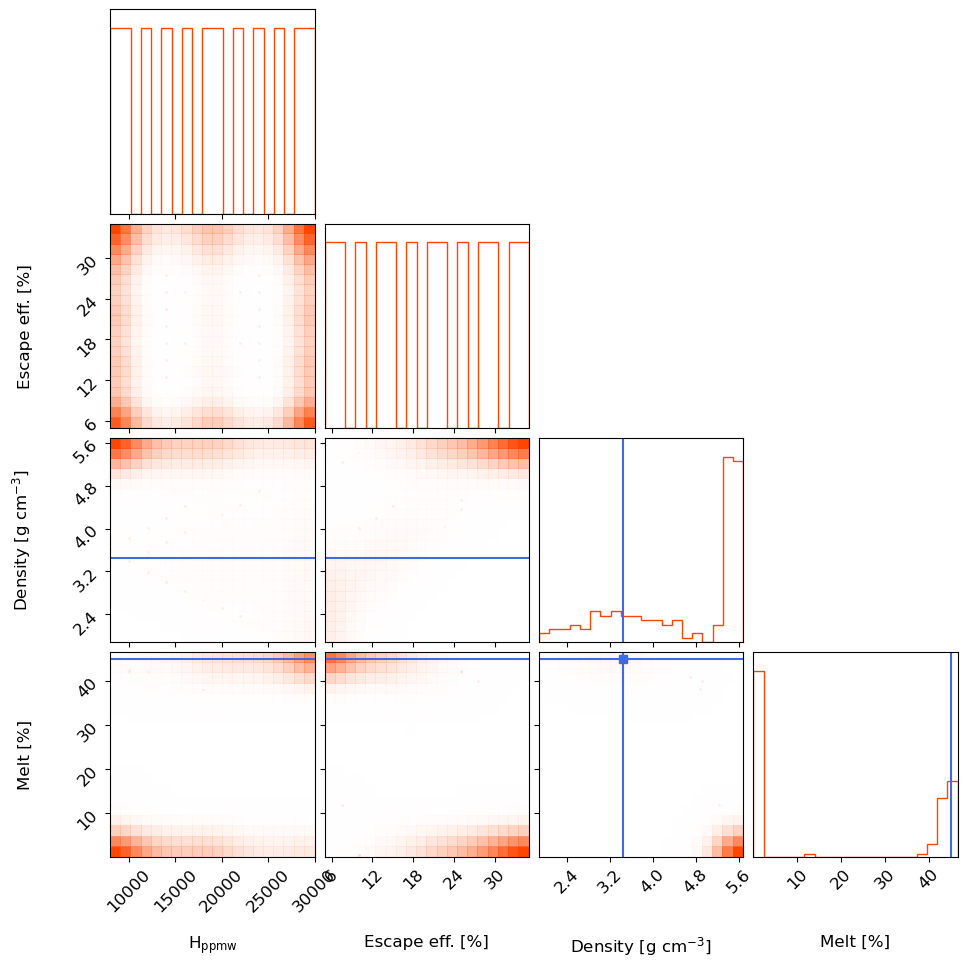

In [29]:
keys = []
lbls = []
scls = []
trth = []

keys.append("delivery.elements.H_ppmw")
lbls.append(r"H$_\text{ppmw}$")
scls.append(1.0)
trth.append(None)

# keys.append("delivery.elements.SH_ratio")
# lbls.append("S/H ratio")
# scls.append(1.0)
# trth.append(None)

# keys.append("outgas.fO2_shift_IW")
# lbls.append(r"$\Delta$IW")
# scls.append(1.0)
# trth.append(None)

keys.append("escape.zephyrus.efficiency")
lbls.append(r"Escape eff. [%]")
scls.append(1e2)
trth.append(3.17)

keys.append("rho_obs")
lbls.append(r"Density [g cm$^{-3}$]")
scls.append(1e-3)
trth.append(3.45)

keys.append("Phi_global")
lbls.append(r"Melt [%]")
scls.append(100.0)
trth.append(45)

# keys.append("H2S_vmr")
# lbls.append("H$_2$S VMR%")
# scls.append(100.0)
# trth.append(10**(-0.74)*100)


samples = []
for i in range(ncases):

    # find closest index in helpfile
    help = helps[i].iloc[3:]
    t_arr = np.array(help["Time"]) + age_start
    idx_close = np.argmin(np.abs(t_arr - age_obs["mu"]))

    row = []

    for j in range(len(keys)):
        xkey = keys[j]
        if "." in xkey:
            x = lg.descend_get(confs[i], xkey)
        else:
            x = help[xkey].iloc[idx_close]
        row.append(x*scls[j])

    samples.append(row)

samples = np.array(samples)


figscale = 1.1
fig = plt.figure(figsize=(9*figscale,9*figscale))
corner.corner(samples, labels=lbls, truths=trth, truth_color='royalblue',
                    plot_contours=False, smooth=2,
                    fig=fig, labelpad=0.08, color='orangered')
fig.savefig("output/corner.pdf", bbox_inches='tight')
plt.show()